# Time Series Analysis with Recurrent Neural Networks (Keras)

1. Get Data
2. Explore Data
3. Clean and prepare data
4. Split into training and testing sets
5. Assemble Model
6. Train Model
7. Evaluate Model
8. Profit?

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(True)

Num GPUs Available:  1


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6681963342561482556
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6661821563
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8163404949000517027
physical_device_desc: "device: 0, name: GeForce GTX 1070 Ti, pci bus id: 0000:07:00.0, compute capability: 6.1"
]


## 1. Get Data

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import math

df = pd.read_csv('../Historical Data/AMZN.csv')
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5858.000000,5858.000000,5858.000000,5858.000000,5858.000000,5.858000e+03
mean,380.419448,384.733352,375.742883,380.467606,380.467606,7.509038e+06
std,603.067205,609.532303,595.982506,603.144412,603.144412,7.275354e+06
min,1.406250,1.447917,1.312500,1.395833,1.395833,4.872000e+05
25%,38.000000,38.621249,37.262498,37.950001,37.950001,3.681750e+06
50%,83.854999,85.180001,82.215000,83.799999,83.799999,5.647800e+06
75%,363.579994,367.755005,358.912498,363.812493,363.812493,8.513075e+06
max,3310.149902,3380.320068,3275.389893,3312.489990,3312.489990,1.043292e+08


In [4]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5858 entries, 0 to 5857
Data columns (total 7 columns):
Date         5858 non-null object
Open         5858 non-null float64
High         5858 non-null float64
Low          5858 non-null float64
Close        5858 non-null float64
Adj Close    5858 non-null float64
Volume       5858 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 320.5+ KB


In [6]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200


In [7]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
5853,2020-08-18,3212.000000,3320.000000,3205.820068,3312.489990,3312.489990,5346000
5854,2020-08-19,3303.010010,3315.899902,3256.000000,3260.479980,3260.479980,4185100
5855,2020-08-20,3252.000000,3312.620117,3238.000000,3297.370117,3297.370117,3332500
5856,2020-08-21,3295.000000,3314.399902,3275.389893,3284.719971,3284.719971,3575900
5857,2020-08-24,3310.149902,3380.320068,3257.560059,3307.459961,3307.459961,4661000


## 2. Explore Data

C:\Users\Joe\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


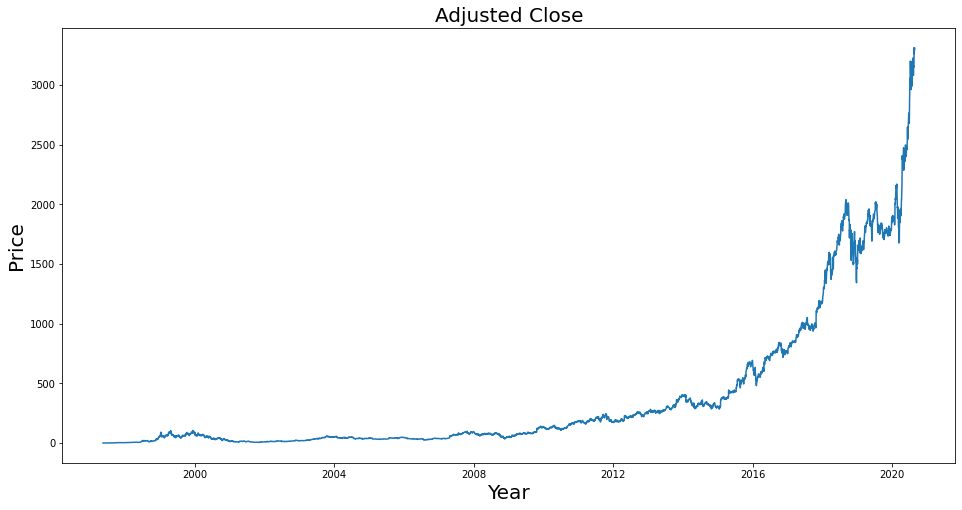

In [8]:
df['Date'] = pd.to_datetime(df['Date']) 
x = df.Date
Y = df['Adj Close']

plt.figure(figsize=[16,8])
plt.plot(x,Y)
plt.xlabel('Year',fontsize=20)
plt.ylabel('Price',fontsize=20)
plt.title('Adjusted Close',fontsize=20)
plt.show()


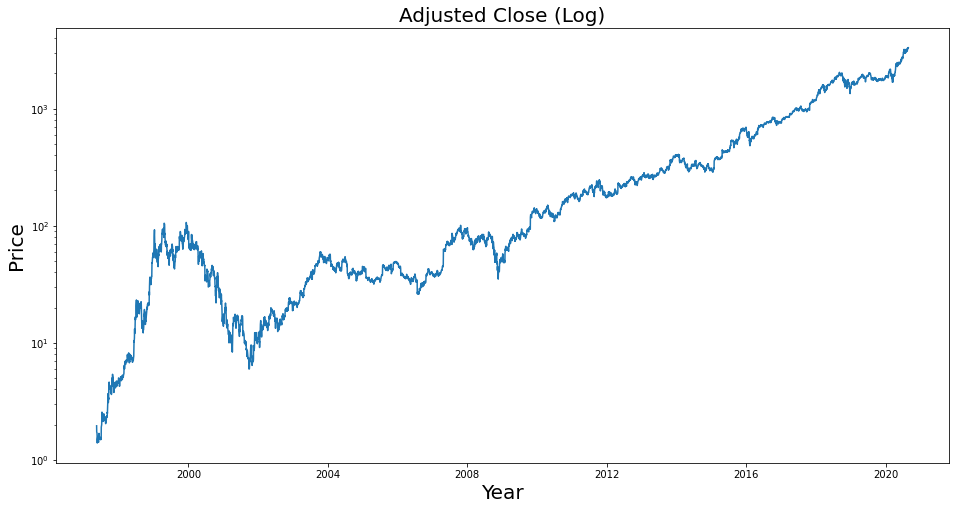

In [9]:
plt.figure(figsize=[16,8])
plt.plot(x,Y)
plt.xlabel('Year',fontsize=20)
plt.ylabel('Price',fontsize=20)
plt.title('Adjusted Close (Log)',fontsize=20)
plt.yscale('log')
plt.show()

In [10]:
df['Adj High'] = (df['Adj Close']/df['Close'])*df['High']
df['Adj Low'] = (df['Adj Close']/df['Close'])*df['Low']
df['Adj Volume'] = df['Volume']

data=df[['Adj Close','Adj Volume','Adj High','Adj Low']]
data.head()

,Adj Close,Adj Volume,Adj High,Adj Low
0,1.958333,72156000,2.500000,1.927083
1,1.729167,14700000,1.979167,1.708333
2,1.708333,6106800,1.770833,1.625000
3,1.635417,5467200,1.750000,1.635417
4,1.427083,18853200,1.645833,1.375000


## 3. Clean and Prepare Data

In [11]:
dataCopy = data.copy()

data.loc[:,('dailyReturn')] = np.log(dataCopy.loc[:,('Adj Close')]/dataCopy.loc[:,('Adj Close')].shift(1))
data.loc[:,'weeklyReturn'] = np.log(dataCopy.loc[:,'Adj Close']/dataCopy.loc[:,'Adj Close'].shift(5))
data.loc[:,'dailyHL'] = np.log(dataCopy.loc[:,'Adj High']/dataCopy['Adj Low'])
data.loc[:,'weeklyHL'] = np.log(dataCopy.loc[:,'Adj High'].rolling(6).max()/dataCopy.loc[:,'Adj Low'].rolling(6).min())
data.head(12)

C:\Users\Joe\Anaconda3\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Joe\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Adj Close,Adj Volume,Adj High,Adj Low,dailyReturn,weeklyReturn,dailyHL,weeklyHL
0,1.958333,72156000,2.500000,1.927083,NaN,NaN,0.260283,NaN
1,1.729167,14700000,1.979167,1.708333,-0.124454,NaN,0.147158,NaN
2,1.708333,6106800,1.770833,1.625000,-0.012122,NaN,0.085942,NaN
3,1.635417,5467200,1.750000,1.635417,-0.043620,NaN,0.067718,NaN
4,1.427083,18853200,1.645833,1.375000,-0.136265,NaN,0.179793,NaN
5,1.395833,11776800,1.447917,1.312500,-0.022141,-0.338602,0.098192,0.644357
6,1.500000,15937200,1.520833,1.333333,0.071974,-0.142175,0.131576,0.410742
7,1.583333,8697600,1.645833,1.458333,0.054067,-0.075986,0.120953,0.299516
8,1.531250,4574400,1.635417,1.531250,-0.033448,-0.065813,0.065813,0.287682
9,1.505208,3472800,1.541667,1.479167,-0.017153,0.053299,0.041385,0.226313


In [12]:
data = data.dropna(how='any')
data.head()

,Adj Close,Adj Volume,Adj High,Adj Low,dailyReturn,weeklyReturn,dailyHL,weeklyHL
5,1.395833,11776800,1.447917,1.312500,-0.022141,-0.338602,0.098192,0.644357
6,1.500000,15937200,1.520833,1.333333,0.071974,-0.142175,0.131576,0.410742
7,1.583333,8697600,1.645833,1.458333,0.054067,-0.075986,0.120953,0.299516
8,1.531250,4574400,1.635417,1.531250,-0.033448,-0.065813,0.065813,0.287682
9,1.505208,3472800,1.541667,1.479167,-0.017153,0.053299,0.041385,0.226313


In [13]:
def toTimeSeries(df,columns,n_trail=1,n_lead=1):
    df = df[columns]
    n_columns=len(columns)
    cols=[]
    names=[]
    
    # Create trailing columns
    for i in range(n_trail,0,-1):
        cols.append(df.shift(i))
        names += [(columns[j]+'(t-%d)'%(i))  for j in range(n_columns)]
        
    # Create leading columns
    for i in range(0,n_lead+1):
        cols.append(df.shift(-i))
        names += [(columns[j]+'(t+%d)'%(i))  for j in range(n_columns)]
        
    agg = pd.concat(cols,axis=1)
    agg.columns = names
    
    # Clean up NaN rows
    agg.dropna(inplace=True)
    
    return agg

In [14]:
n_trail = 5
n_lead = 5
columns = ['dailyReturn','weeklyReturn','dailyHL','weeklyHL']

reframed = toTimeSeries(data,columns,n_trail,n_lead)
print(reframed.head())

    dailyReturn(t-5)  weeklyReturn(t-5)  dailyHL(t-5)  weeklyHL(t-5)  \
10         -0.022141          -0.338602      0.098192       0.644357   
11          0.071974          -0.142175      0.131576       0.410742   
12          0.054067          -0.075986      0.120953       0.299516   
13         -0.033448          -0.065813      0.065813       0.287682   
14         -0.017153           0.053299      0.041385       0.226313   

    dailyReturn(t-4)  weeklyReturn(t-4)  dailyHL(t-4)  weeklyHL(t-4)  \
10          0.071974          -0.142175      0.131576       0.410742   
11          0.054067          -0.075986      0.120953       0.299516   
12         -0.033448          -0.065813      0.065813       0.287682   
13         -0.017153           0.053299      0.041385       0.226313   
14         -0.003466           0.071974      0.020907       0.226313   

    dailyReturn(t-3)  weeklyReturn(t-3)  ...  dailyHL(t+3)  weeklyHL(t+3)  \
10          0.054067          -0.075986  ...      0.06500

## 4. Split in Training and Testing Data

In [15]:
values = reframed.values

trainTestSplit = 0.75

mask = np.random.rand(len(values)) < trainTestSplit

train = values[mask,:]
test = values[~mask,:]
print(train.shape)

# Number of features
n_columns = len(columns)
n_features = (n_lead - 1) * n_columns
n_periods = n_trail + 1

# Number of periods in observation
n_obs = n_periods * n_columns

# Assign test and training sets
X_train, Y_train = train[:,0:n_obs], train[:,-n_features:]
print(X_train.shape)
X_train = X_train.reshape((X_train.shape[0], n_periods, n_columns))

X_test, Y_test = test[:,0:n_obs], test[:,-n_features:]
X_test = X_test.reshape((X_test.shape[0], n_periods, n_columns))
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

new_train = []
for i, train in enumerate(Y_train):
    new_train.append(Y_train[i][-n_columns:].tolist())
Y_train = np.array(new_train)

new_test = []
for i, test in enumerate(Y_test):
    new_test.append(Y_test[i][-n_columns:].tolist())
Y_test = np.array(new_test)

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(4367, 44)
(4367, 24)
(4367, 6, 4) (4367, 16) (1476, 6, 4) (1476, 16)
(4367, 6, 4) (4367, 4) (1476, 6, 4) (1476, 4)


## 5. Assemble the Model

In [16]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

with tf.device('/GPU:0'):
    model = Sequential()
    model.add(LSTM(50,return_sequences=True,input_shape=(X_train.shape[1:])))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(len(columns)))
    model.compile(loss='mae',optimizer='Adam')

Using TensorFlow backend.


Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ConcatV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0

In [17]:
print(model.summary())
model.get_config()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 6, 50)             11000     
_________________________________________________________________
lstm_2 (LSTM)                (None, 6, 50)             20200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 204       
Total params: 51,604
Trainable params: 51,604
Non-trainable params: 0
_________________________________________________________________
None


{'name': 'sequential_1',
 'layers': [{'class_name': 'LSTM',
   'config': {'name': 'lstm_1',
    'trainable': True,
    'batch_input_shape': (None, 6, 4),
    'dtype': 'float32',
    'return_sequences': True,
    'return_state': False,
    'go_backwards': False,
    'stateful': False,
    'unroll': False,
    'units': 50,
    'activation': 'tanh',
    'recurrent_activation': 'sigmoid',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_avg',
      'distribution': 'uniform',
      'seed': None}},
    'recurrent_initializer': {'class_name': 'Orthogonal',
     'config': {'gain': 1.0, 'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'unit_forget_bias': True,
    'kernel_regularizer': None,
    'recurrent_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'recurrent_constraint': None,
    'bias_constraint': None,

## 6. Train the Model

Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Reshape in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Train on 4367 samples, validate on 1476 samples
Epoch 1/50
Executing op __inference_keras_scratch_graph_3622 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_keras_scratch_graph_3926 in 

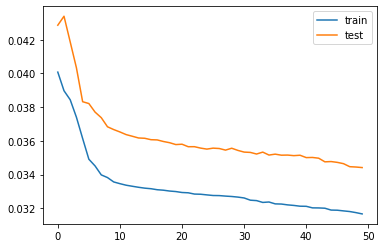

In [18]:
# fit network
history = model.fit(X_train, Y_train, epochs=50, batch_size=72, validation_data=(X_test, Y_test), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 7. Evaluate the Model

In [19]:
Y_predicted = model.predict(X_test)
results = pd.DataFrame(Y_test)
col1, col2, col3, col4 = [],[],[],[]

for pred in Y_predicted:
    col1.append(pred[0])
    col2.append(pred[1])
    col3.append(pred[2])
    col4.append(pred[3])

results[2], results[3], results[4], results[5] = col1, col2, col3, col4
results.columns = ['Daily Return','Weekly Return','Predicted Daily', 'Predicted Weekly', 
                   'Daily HL', 'Weekly HL']
results.head()

Executing op __inference_keras_scratch_graph_20614 in device /job:localhost/replica:0/task:0/device:GPU:0


,Daily Return,Weekly Return,Predicted Daily,Predicted Weekly,Daily HL,Weekly HL
0,0.071692,0.099091,-0.010038,-0.030257,0.066703,0.162336
1,0.000000,0.000000,0.002894,0.002115,0.027564,0.089431
2,0.140667,0.400950,0.003401,0.008177,0.019785,0.077391
3,-0.021714,-0.132311,-0.008328,-0.011221,0.080943,0.225124
4,-0.013730,0.018605,-0.005347,-0.020198,0.076126,0.213948


In [20]:
results['Prop'] = results['Weekly Return']/results['Predicted Weekly']

results['Correct'] = results['Prop'].apply(lambda x : 1 if x > 0.5 and x < 2 else 0)
results['Correct2'] = (results['Weekly Return']*results['Predicted Weekly']).apply(lambda x : 1 if x > 0 else 0)

print('Direction and Magnitude Accuracy Score: ', results.Correct.sum()/results.Correct.count())
print('Direction Only Accuracy Score: ', results.Correct2.sum()/results.Correct2.count())

Direction and Magnitude Accuracy Score:  0.09281842818428185
Direction Only Accuracy Score:  0.524390243902439


In [21]:
np.corrcoef(results['Weekly Return'], results['Predicted Weekly'])

array([[ 1.        , -0.00493768],
       [-0.00493768,  1.        ]])

In [22]:
results['Risk-Reward'] = results['Predicted Weekly']/results['Weekly HL']
analyze = results.copy(deep=True)

buySignal = analyze['Risk-Reward'].quantile(0.95)
sellSignal = analyze['Risk-Reward'].quantile(0.05)

print('Buy Signal: ', buySignal)
print('Sell Signal: ', sellSignal)

Buy Signal:  0.17993224112590284
Sell Signal:  -0.07424247950943458


In [23]:
analyze = analyze[(analyze['Risk-Reward'] > buySignal) | (analyze['Risk-Reward'] <= sellSignal)]
print('Trade Signal x% of the time: ', analyze.shape[0]/results.shape[0])
analyze.head()

Trade Signal x% of the time:  0.1002710027100271


,Daily Return,Weekly Return,Predicted Daily,Predicted Weekly,Daily HL,Weekly HL,Prop,Correct,Correct2,Risk-Reward
0,0.071692,0.099091,-0.010038,-0.030257,0.066703,0.162336,-3.274937,0,0,-0.186387
4,-0.013730,0.018605,-0.005347,-0.020198,0.076126,0.213948,-0.921152,0,0,-0.094406
5,0.041196,0.062448,-0.006679,-0.022843,0.056265,0.146952,-2.733802,0,0,-0.155445
21,-0.002594,-0.016742,-0.013319,-0.015830,0.072190,0.188842,1.057624,1,1,-0.083826
22,-0.065840,-0.067139,-0.005647,-0.015990,0.064109,0.183484,4.198723,0,1,-0.087149


In [24]:
import sklearn
from sklearn.linear_model import LinearRegression

X = analyze['Risk-Reward']
Y = analyze['Weekly Return']

X = np.array(X).reshape(len(X),1)
Y = np.array(Y).reshape(len(Y),1)

lr = LinearRegression()
lr = lr.fit(X,Y)
preds = lr.predict(X)

from sklearn.metrics import r2_score

print('R^2 Score: ', r2_score(Y,preds))

R^2 Score:  0.0007344560188259353


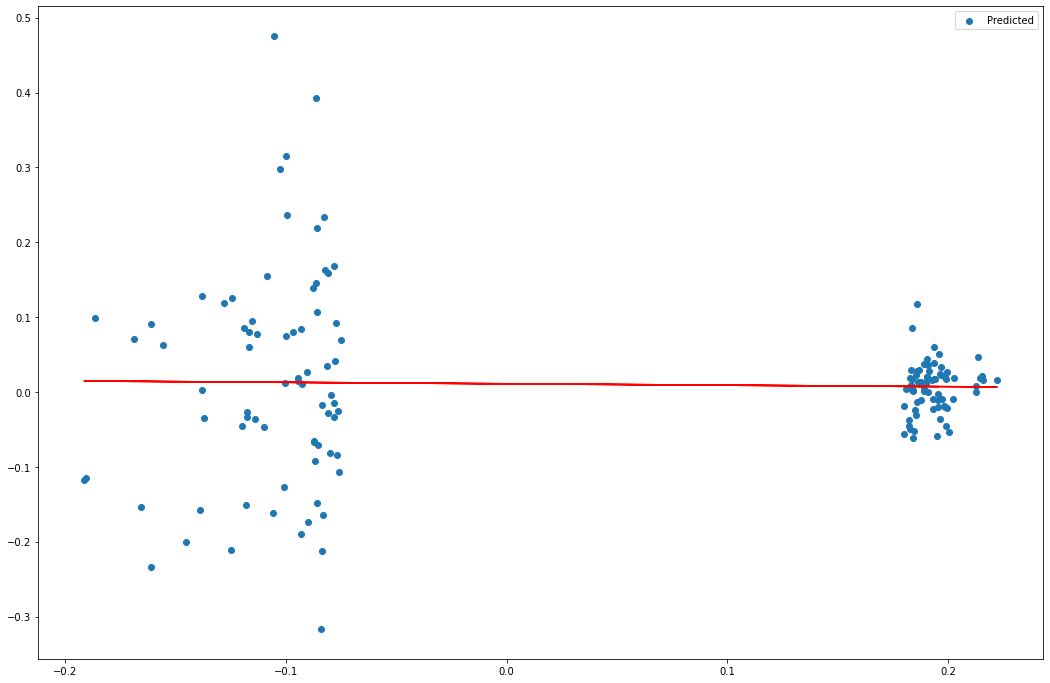

In [25]:
plt.figure(figsize=(18,12))
time = list(range(0,len(X)))
plt.scatter(X,Y,label='Predicted')
plt.plot(X,preds,color='r')
plt.legend()
plt.show()

## 8. Profit?

In [26]:
portfolio = [1000]
hodl = [1000]
bpFee = 20
feeModifier = 1 - (bpFee / 10000)

predicted = results['Predicted Weekly'].tolist()
actual = results['Weekly Return'].tolist()
riskReward = results['Risk-Reward'].tolist()

for prediction in riskReward:
    idx = riskReward.index(prediction)
    if prediction > buySignal:
        today = np.exp(actual[idx])*(portfolio[-1]*feeModifier)
    elif prediction < sellSignal:
        today = np.exp(-actual[idx])*(portfolio[-1]*feeModifier)
    else:
        today = portfolio[-1]
    portfolio.append(today)
    
    hodl.append(np.exp(actual[idx])*hodl[-1])
    
print('Annualized Return: ', ((((portfolio[-1]-1000)/1000)+1)**(52/len(portfolio))-1)*100,'%')

Annualized Return:  -3.530342398053299 %


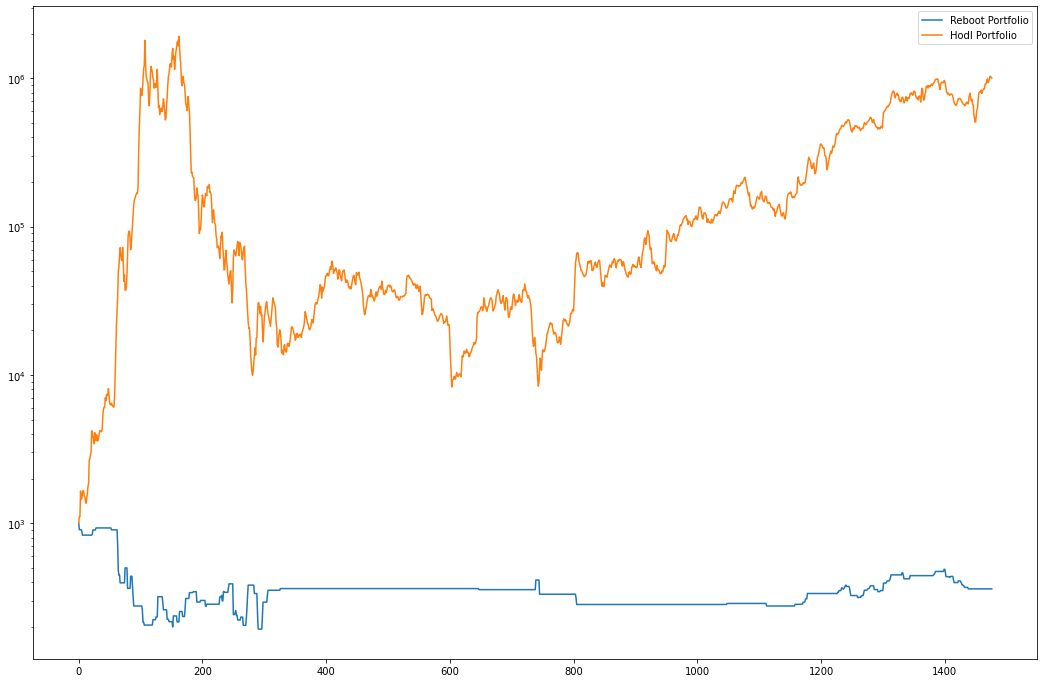

In [27]:
plt.figure(figsize=(18,12))
time = list(range(0,len(portfolio)))
plt.plot(time,portfolio,label='Reboot Portfolio')
plt.plot(time,hodl,label='Hodl Portfolio')
plt.legend()
plt.yscale('log')
plt.show()

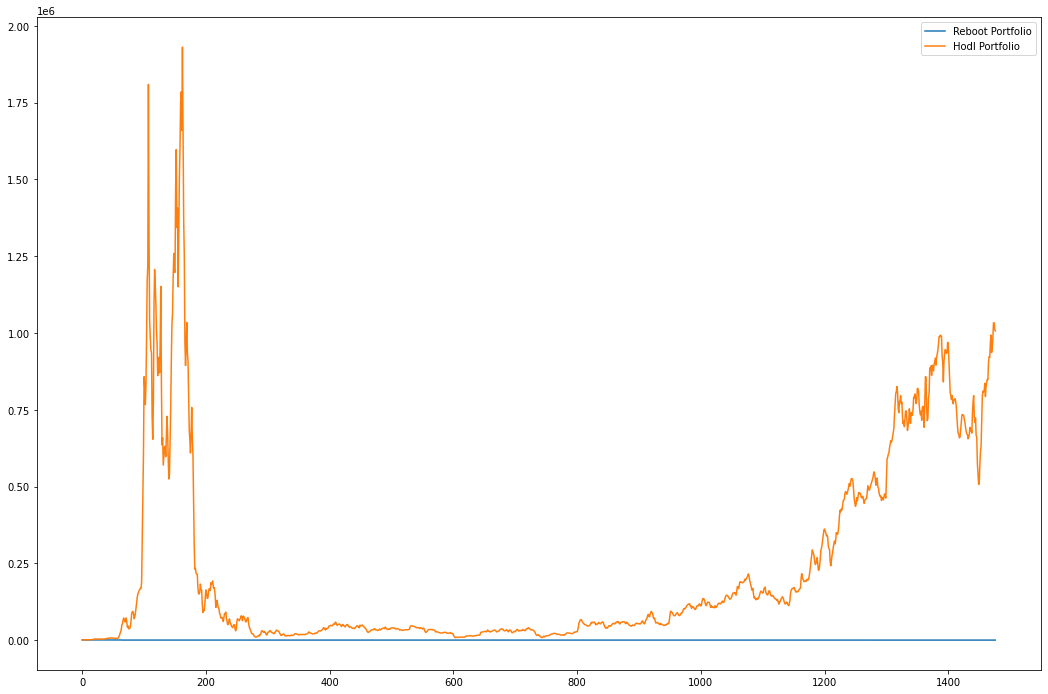

In [28]:
plt.figure(figsize=(18,12))
time = list(range(0,len(portfolio)))
plt.plot(time,portfolio,label='Reboot Portfolio')
plt.plot(time,hodl,label='Hodl Portfolio')
plt.legend()
plt.show()

In [34]:
port_df = pd.DataFrame(portfolio,index=time,columns=['portfolio'])
port_df['hodl'] = hodl
port_df['symbol'] = 'AMZN'

port_df = port_df.head(df[::4].shape[0])
port_df['Date'] = df[::4].Date.tolist()
port_df = port_df[['Date','portfolio','hodl','symbol']]
port_df.to_csv('../Results Data/AMZN_results.csv',index=False)
port_df

,Date,portfolio,hodl,symbol
0,1997-05-15,1000.000000,1000.000000,AMZN
1,1997-05-21,903.849057,1104.166667,AMZN
2,1997-05-28,903.849057,1104.166667,AMZN
3,1997-06-03,903.849057,1648.788819,AMZN
4,1997-06-09,903.849057,1444.451969,AMZN
...,...,...,...,...
1460,2020-07-30,360.277299,793157.973350,AMZN
1461,2020-08-05,360.277299,825011.146875,AMZN
1462,2020-08-11,360.277299,838946.389289,AMZN
1463,2020-08-17,360.277299,849582.983516,AMZN


In [31]:
df[::4]

,Date,Open,High,Low,Close,Adj Close,Volume,Adj High,Adj Low,Adj Volume
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000,2.500000,1.927083,72156000
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200,1.645833,1.375000,18853200
8,1997-05-28,1.625000,1.635417,1.531250,1.531250,1.531250,4574400,1.635417,1.531250,4574400
12,1997-06-03,1.531250,1.531250,1.479167,1.479167,1.479167,1183200,1.531250,1.479167,1183200
16,1997-06-09,1.656250,1.708333,1.656250,1.687500,1.687500,2352000,1.708333,1.656250,2352000
...,...,...,...,...,...,...,...,...,...,...
5840,2020-07-30,3014.000000,3092.000000,3005.000000,3051.879883,3051.879883,6128300,3092.000000,3005.000000,6128300
5844,2020-08-05,3143.770020,3213.590088,3127.300049,3205.030029,3205.030029,3930000,3213.590088,3127.300049,3930000
5848,2020-08-11,3113.199951,3159.219971,3073.000000,3080.669922,3080.669922,3718100,3159.219971,3073.000000,3718100
5852,2020-08-17,3173.120117,3194.969971,3154.179932,3182.409912,3182.409912,2691200,3194.969971,3154.179932,2691200


In [32]:
port_df.shape[0]

1477